# **Trabajo personal**

*Santiago Lamas Fresard*

Con respecto al archivo de la semana 1: borré los modelos con errores.

## **MultiagedForests.jl**

*Single-species, multiaged forest model, taken from "A Discussion of Vintage Optimization Models in Forest Economics", A. Piazza, Forest Science, Vol 66(4) pp.469-477, 2020.*

In [1]:
using JuMP
using SDDP
using Ipopt
using Gurobi
import Plots
import PiecewiseLinearOpt as PLO

const GRB_ENV = Gurobi.Env()

Set parameter Username
Set parameter LicenseID to value 2760931
Academic license - for non-commercial use only - expires 2027-01-05


Gurobi.Env(Ptr{Nothing} @0x0000025fb930c750, false, 0)

In [14]:
# Entrega el conjunto de operadores soportados para expresiones no lineales.
print(MOI.get(Ipopt.Optimizer(), MOI.ListOfSupportedNonlinearOperators()))

[:+, :-, :abs, :sign, :sqrt, :cbrt, :abs2, :inv, :log, :log10, :log2, :log1p, :exp, :exp2, :expm1, :sin, :cos, :tan, :sec, :csc, :cot, :sind, :cosd, :tand, :secd, :cscd, :cotd, :asin, :acos, :atan, :asec, :acsc, :acot, :asind, :acosd, :atand, :asecd, :acscd, :acotd, :sinh, :cosh, :tanh, :sech, :csch, :coth, :asinh, :acosh, :atanh, :asech, :acsch, :acoth, :deg2rad, :rad2deg, :erf, :erfinv, :erfc, :erfcinv, :erfi, :gamma, :lgamma, :digamma, :invdigamma, :trigamma, :airyai, :airybi, :airyaiprime, :airybiprime, :besselj0, :besselj1, :bessely0, :bessely1, :erfcx, :dawson, :*, :^, :/, :ifelse, :min, :max, :&&, :||, :<=, :(==), :>=, :<, :>]

In [15]:
UB = 1000 # upper bound for the objective function
b = 0.975 # discount factor used by Buongiorno
α = 0.5 # risk aversion parameter for the utility function
n = 5 # number of age classes
f = [0.8, 4.2, 16.99, 68.1, 84] # biomass coeffcients
x0 = [1.0, 0.0, 0.0, 0.0, 0.0] # initial state

5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0

In [16]:
# Creamos un gráfico cíclico de un nodo con probablidad (1-b) de salir del ciclo 
graph = SDDP.UnicyclicGraph(b; num_nodes = 1)

Root
 0
Nodes
 1
Arcs
 0 => 1 w.p. 1.0
 1 => 1 w.p. 0.975

### *Trabajo: estimación de la función de costos*

En primer lugar se aproxima la función objetivo mediante una función cuadrática: se busca aquella función $x\mapsto ax^2 + bx +c$ que minimice 
$$
\int_0^T \left( \frac{x^{1-\alpha}}{1-\alpha} - (ax^2 + bx +c) \right)^2 dx
$$
el criterio de primer orden entrega que los parámetros óptimos son
$$
\begin{pmatrix} a \\ b \\ c \end{pmatrix} = \frac{1}{1-\alpha}
\begin{pmatrix} 
\frac{T^5}5 & \frac{T^4}4 & \frac{T^3}3 \\
\frac{T^4}4 & \frac{T^3}3 & \frac{T^2}2 \\
\frac{T^3}3 & \frac{T^2}2 & T \\
\end{pmatrix}^{-1}
\begin{pmatrix}
\frac{T^{4-\alpha}}{4-\alpha} \\ \frac{T^{3-\alpha}}{3-\alpha} \\ \frac{T^{2-\alpha}}{2-\alpha} 
\end{pmatrix}
$$

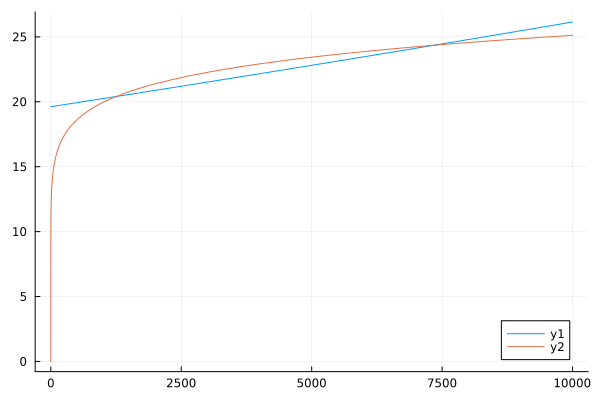

In [17]:
# Aproximación mediante una función cuadrática.

function optimal_params(α, T)
    A = [T^5/5 T^4/4 T^3/3; T^4/4 T^3/3 T^2/2; T^3/3 T^2/2 T]
    b = [T^(4-α)/(4-α); T^(3-α)/(3-α); T^(2-α)/(2-α)]/(1-α)
    return A^-1*b
end

a_ej, b_ej, c_ej = optimal_params(0.9, 10000)

function quad_ej(x)
    return a_ej*x^2 + b_ej*x + c_ej
end

function raiz_ej(x)
    return x^(1-9/10)/((1-9/10))
end

using Plots

plot(quad_ej, 0,10000)
plot!(raiz_ej, 0, 10000)

Lo siguiente fue aproximar superiormente la función objetivo: dada una colección de puntos $\{x_i\}_{i=1}^N$, se calculan las rectas tangentes a la función objetivo en dichos puntos:
$$
a_i x + b_i,\quad a_i = f'(x_i),\, a_i x_i + b_i = f(x_i) \Rightarrow b_i = f(x_i) - a_i x_i,
$$
y se hace la transformación del problema
$$
\max_{TV}\quad f(TV) \\
\text{s.a.}\quad TV\in C
$$
equivalente a 
$$
\max_{u}\quad u \\
\text{s.a.}\quad u\leq f(TV) \\ 
\quad TV\in C
$$


por la siguiente aproximación
$$
\max_{u}\quad u \\
\text{s.a.}\quad u\leq a_i TV + b_i,\, i=1,\ldots, N \\ 
\quad TV\in C
$$

La otra forma de realizar esto fue aproximando inferiormente la función, utilizando las rectas $x\mapsto a_i x + b_i = \frac{f(x_{i+1}) - f(x_i)}{x_{i+1} - x_i}(x - x_i) + f(x_i)$

In [18]:
nx = 2500
dx = 250000/nx
ny = 100
dy = 1000/ny

# Aproximación linear por trozos
function approx_linear(x)
  i_dx = floor(x/dx)
  dy = sqrt((i_dx +1)*dx) - sqrt(i_dx*dx)
  return dy/dx * (x - i_dx*dx) + sqrt(i_dx*dx)
end

# Aproximación por una función cuadrática
a, b, c = optimal_params(α, UB^2/4)
function approx_quad(x)
  return a*x^2 + b*x + c
end

function obj(x)
  return x^(1-α)/(1-α)
end

function deriv_obj(x)
  return x^-α
end

function inv_obj(y)
  return ((1-α)*y)^(1/(1-α))
end

d_unif_x = 1:dx:250000
d_unif_y = 1:dy:1000

f_unif_x = obj.(d_unif_x)
f_inv_y = inv_obj.(d_unif_y)

# Aproximación mediante tangentes:
# eje x
as1_x = deriv_obj.(d_unif_x)
bs1_x = f_unif_x .- as1_x .* d_unif_x
# eje y
as1_y = deriv_obj.(f_inv_y)
bs1_y = d_unif_y .- as1_y .* f_inv_y 

# Aproximación mediante interpolación lineal:
# eje x
as2_x = [(f_unif_x[i+1] - f_unif_x[i])/dx for i in 1:nx-1]
bs2_x = f_unif_x[1:nx-1] .- as2_x .* d_unif_x[1:nx-1]
# eje y
as2_y = [dy/(f_inv_y[i+1] - f_inv_y[i]) for i in 1:ny-1]
bs2_y = d_unif_y[1:ny-1] .- as2_y .* f_inv_y[1:ny-1]

99-element Vector{Float64}:
   0.9166666666666666
   7.21875
  12.519230769230768
  17.65277777777778
  22.72826086956522
  27.776785714285715
  32.81060606060606
  37.83552631578947
  42.854651162790695
  47.86979166666667
  52.882075471698116
  57.89224137931035
  62.90079365079365
   ⋮
 437.98573059360734
 442.98589164785557
 447.9860491071429
 452.98620309050773
 457.9863537117904
 462.9865010799136
 467.98664529914527
 472.98678646934457
 477.98692468619254
 482.98706004140786
 487.9871926229508
 492.987322515213

In [19]:
model0 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
    end)
    @stageobjective(sp, approx_quad(TV))
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


In [20]:
model1 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:nx], u <= as1_x[s]*TV + bs1_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


In [21]:
model2 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:ny], u <= as1_y[s]*TV + bs1_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


In [22]:
model3 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: nx-1], u <= as2_x[s]*TV + bs2_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


In [23]:
model4 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: ny-1], u <= as2_y[s]*TV + bs2_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


### **ENTRENAMIENTO Y RESOLUCIÓN**

In [24]:
n_train_iterations = 50
n_simulations = 1

1

In [25]:
println("Aproximación cuadrática:")
SDDP.numerical_stability_report(model0)
println("")
println("Aproximación tangencial uniforme en x:")
SDDP.numerical_stability_report(model1)
println("")
println("Aproximación tangencial uniforme en y:")
SDDP.numerical_stability_report(model2)
println("")
println("Aproximación interpolando uniforme en x:")
SDDP.numerical_stability_report(model3)
println("")
println("Aproximación interpolando uniforme en y:")
SDDP.numerical_stability_report(model4)

Aproximación cuadrática:
numerical stability report
  matrix range     [8e-01, 8e+01]
  objective range  [0e+00, 0e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 1e+00]

Aproximación tangencial uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]

Aproximación tangencial uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]

Aproximación interpolando uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]

Aproximación interpolando uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+

In [26]:
SDDP.train(model0, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model0, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model0)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [17, 17]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [5, 5]
  VariableRef in MOI.GreaterThan{Float64} : [11, 11]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [8e-01, 8e+01]
  objective range  [0e+00, 0e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 1e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid


In [27]:
SDDP.train(model1, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model1, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model1)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [2505, 2505]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

In [28]:
SDDP.train(model2, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model2, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model2)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [105, 105]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  

In [29]:
SDDP.train(model3, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model3, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model3)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [2504, 2504]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

In [30]:
SDDP.train(model4, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model4, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model4)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [104, 104]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  

# **Simulaciones de los procesos OU***

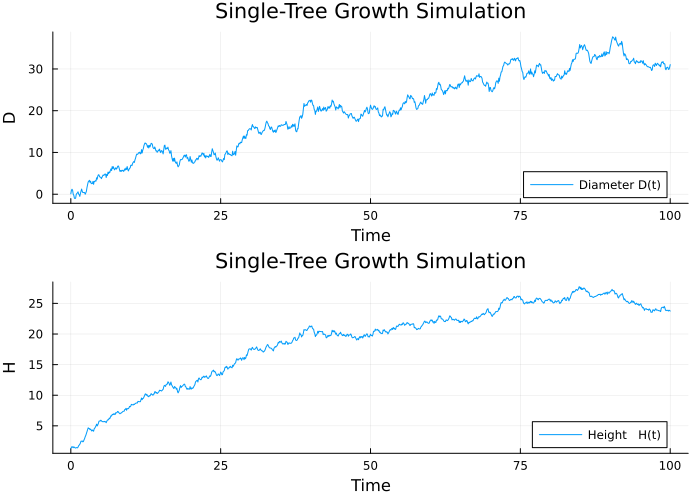

In [2]:
# single-path simulation of diameter and height processes

using LinearAlgebra, Distributions, Random, Plots

# ─────────────────────────────────────────────
# 1. Paper’s fixed‐effects parameter estimates. With these, the matrix is not positive definite.
# α_d, β_d, σ11  = 35.3462, 0.0280, 3.5968
# α_h, β_h, σ22  = 25.3301, 0.0396, 1.1968
# σ12           = 3.9187

# 1. Model parameters (fixed-effects drift ⨯ mixed-effects diffusion)
α_d, β_d      = 35.3462, 0.0280        # fixed-effects diameter intercept & pull-back (Table 2 in the paper)
α_h, β_h      = 25.3301, 0.0396        # fixed-effects height intercept & pull-back (Table 2 in the paper)
σ11, σ12, σ22 = 2.3736, 0.6334, 0.3615  # mixed-effects diffusion entries (PD!). For the fixed ones,the matrix is singular


# 2. Build drift + diffusion
Δt      = .1     # time step
Γ = Diagonal([β_d, β_h])
F = exp(-Γ * Δt)
Q = [ σ11*(1-exp(-2β_d*Δt))/(2β_d)     σ12*(1-exp(-(β_d+β_h)*Δt))/(β_d+β_h);
      σ12*(1-exp(-(β_d+β_h)*Δt))/(β_d+β_h)   σ22*(1-exp(-2β_h*Δt))/(2β_h) ]

# 3. Equilibrium μ (fixed-effects, φ=0)
μ = [α_d, α_h]   # ≈ [35.35, 25.33]

# 4. Initial condition at t0=5, below μ
T       = 1000     # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0

# 5. Allocate & initialize
Xs = Array{Float64}(undef, 2, T+1)
Xs[:,1] .= x0
Ys = Array{Float64}(undef, 2, T+1)
Ys[:,1] .= x0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Q)
for k in 1:T
    η = rand(rng, dist)
    Xs[:,k+1] = μ .+ F*(Xs[:,k] .- μ) .+ η
end

# 6. Plot the single trajectory
t = 0:Δt:T*Δt

p1 = plot(t, Xs[1,:], label="Diameter D(t)", xlabel="Time", ylabel="D", legend=:bottomright)
p2 = plot(t, Xs[2,:], label="Height   H(t)", xlabel="Time", ylabel="H", legend=:bottomright)

plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [3]:
function A(x)
    d, h = x
    return [β_d*(α_d-d), β_h*(α_h-h)] 
end

B = [σ11 σ12; σ12 σ22]
Ch = cholesky(B).U

2×2 UpperTriangular{Float64, Matrix{Float64}}:
 1.54065  0.411125
  ⋅       0.438721

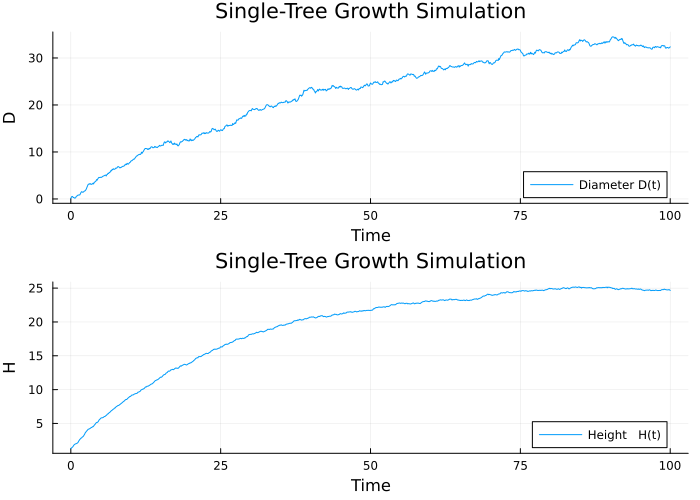

In [4]:
# 4. Initial condition at t0=5, below μ
Δt      = .1     # time step
T       = 1000     # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0

# 5. Allocate & initialize
Xs = Array{Float64}(undef, 2, T+1)
Xs[:,1] .= x0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    η = rand(rng, dist)
    Xs[:,k+1] = Xs[:,k] + A(Xs[:,k])*Δt .+ Ch * η
end

# 6. Plot the single trajectory
t = 0:Δt:T*Δt

p1 = plot(t, Xs[1,:], label="Diameter D(t)", xlabel="Time", ylabel="D", legend=:bottomright)
p2 = plot(t, Xs[2,:], label="Height   H(t)", xlabel="Time", ylabel="H", legend=:bottomright)

plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [5]:
# 4. Initial condition at t0=5, below μ
Δt      = .1     # time step
T       = 1000    # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0
samples = 50000 # number of samples

# 5. Allocate & initialize
Xs = Array{Float64, 3}(undef, 2, T+1, samples)
X0 = reshape(repeat(x0, samples), (2, samples))
Xs[:,1,:] .= X0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    for j in 1:samples
        η = rand(rng, dist)
        Xs[:,k+1,j] = Xs[:,k,j] + A(Xs[:,k,j])*Δt .+ Ch * η
    end
end

In [ ]:
# 6. OPTIONAL: Plot the trajectories
t = 0:Δt:T*Δt
# 
p1 = plot(t, Xs[1,:,:], xlabel="Time", ylabel="D")#, legend=:bottomright)
p2 = plot(t, Xs[2,:,:], xlabel="Time", ylabel="H")#, legend=:bottomright)
# 
plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [6]:
T_sim = floor(Int,T/100)
Ys = floor.(Int, round.(Int, Xs[:,1:100:end,:]) /5)

tr_dict = Dict()
for i in 0:10
    for j in 0:10
        for k in 0:6
            for l in 0:6
                tr_dict[[i,k],[j,l]] = 0
            end
        end
    end
end

for i in 1:samples
    for k in 1:T_sim
        tr_dict[Ys[:,k,i],Ys[:,k+1,i]] += 1
    end
end

sumas_mc = Dict()
valid_idx = []
for i in 0:10
    for k in 0:6
        s = sum(tr_dict[[i,k],[j,l]] for j in 0:10, l in 0:6)
        if s != 0 
            sumas_mc[[i,k]] = s
            push!(valid_idx, [i,k])
        end
    end
end

mc_dict = Dict()
for ik in valid_idx
    s = sumas_mc[ik]
    if s != 0 
        for jl in valid_idx
            tr = tr_dict[ik,jl]
            if tr != 0
                mc_dict[ik,jl] = tr/s
            end
        end 
    end
end

In [8]:
sumas_mc

Dict{Any, Any} with 25 entries:
  [4, 4] => 37629
  [0, 0] => 50000
  [4, 2] => 84
  [5, 3] => 828
  [8, 5] => 33
  [1, 1] => 30391
  [4, 5] => 3
  [5, 4] => 111742
  [2, 1] => 10394
  [1, 3] => 9
  [6, 4] => 89227
  [5, 5] => 4369
  [2, 3] => 6148
  [0, 2] => 5
  [3, 3] => 35484
  [7, 4] => 5354
  [1, 2] => 5283
  [4, 3] => 32376
  [6, 5] => 40265
  [8, 4] => 3
  [7, 5] => 9272
  [2, 2] => 14724
  [3, 4] => 675
  [3, 2] => 15645
  [0, 1] => 57

Estrategia: 

- El resultado anterior induce una cadena de Markov $(\delta_{(0,0)}, P)$ a valores en $D = \{(d,h)\in \{0,\ldots,8\} \times \{0,\ldots,5\}: (d,h)\in\texttt{valid idx}\}$.
- Sea $x = (x_{d,h})_{(d,h)\in D}$ el vector que codifica las cantidades (fracciones) de árboles de acuerdo a su diámetro y altura.
- Se toma $\omega$ como un vector que a cada 